# 1. Predicting Rarity With Just Card Data

Question to answer here - how CONSISTENT are Hearthstone developers with their cards?
Complaints of ramping - newly released cards are much more powerful over time. Is this true?

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

from string import punctuation
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

import statsmodels.tools as sm

%matplotlib inline

In [198]:
df = pd.read_csv('dummies_df_card_list.csv')

In [199]:
list(df.columns)


['attack',
 'cardId',
 'cost',
 'durability',
 'health',
 'name',
 'rarity',
 'text',
 'armor',
 'mech_Adapt',
 'mech_AdjacentBuff',
 'mech_AffectedBySpellPower',
 'mech_Aura',
 'mech_Battlecry',
 'mech_Charge',
 'mech_Combo',
 'mech_Deathrattle',
 'mech_Discover',
 'mech_Divine Shield',
 'mech_Echo',
 'mech_Freeze',
 'mech_ImmuneToSpellpower',
 'mech_Inspire',
 'mech_InvisibleDeathrattle',
 'mech_Jade Golem',
 'mech_Lifesteal',
 'mech_Magnetic',
 'mech_Overkill',
 'mech_Overload',
 'mech_Poisonous',
 'mech_Quest',
 'mech_Recruit',
 'mech_Rush',
 'mech_Secret',
 'mech_Silence',
 'mech_Spell Damage',
 'mech_Stealth',
 'mech_Taunt',
 'mech_Twinspell',
 'mech_Windfury',
 'cardset_Basic',
 'cardset_Blackrock Mountain',
 'cardset_Classic',
 'cardset_Goblins vs Gnomes',
 'cardset_Hall of Fame',
 "cardset_Journey to Un'Goro",
 'cardset_Knights of the Frozen Throne',
 'cardset_Kobolds & Catacombs',
 'cardset_Mean Streets of Gadgetzan',
 'cardset_Naxxramas',
 'cardset_One Night in Karazhan',
 "

## Linear Regression Model

Linear Regression on raw data:

In [200]:
numerical_columns = df._get_numeric_data().columns
features = [c for c in numerical_columns if c != 'rarity_value']
X = df[features]
y = df['rarity_value']

X = sm.add_constant(X)

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [202]:
lr = LinearRegression()
model_1 = lr.fit(X_train, y_train)

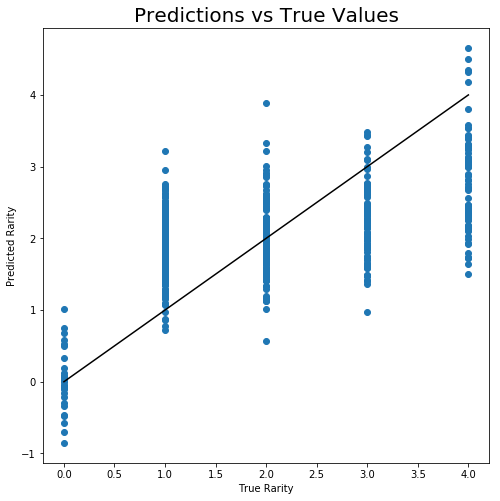

In [203]:
plt.figure(figsize=(8,8))
plt.scatter(y =  model_1.predict(X_test), x = y_test)
plt.title('Predictions vs True Values', fontsize = 20)
plt.xlabel('True Rarity')
plt.ylabel('Predicted Rarity')
plt.plot([0, np.max(y)], [0, np.max(y)], c = 'k');

In [204]:
print('Train Score:', model_1.score(X_train,y_train))
print('Test Score:', model_1.score(X_test,y_test))

Train Score: 0.45344492113491286
Test Score: 0.3663278022653662


Linear Regression on Transformed Data:

In [156]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


In [157]:
model_2 = lr.fit(X_train_scaled, y_train)

In [158]:
print('Train Score:', model_2.score(X_train_scaled,y_train))
print('Test Score:', model_2.score(X_test_scaled,y_test))

Train Score: 0.4505547924265545
Test Score: 0.35886023791517585


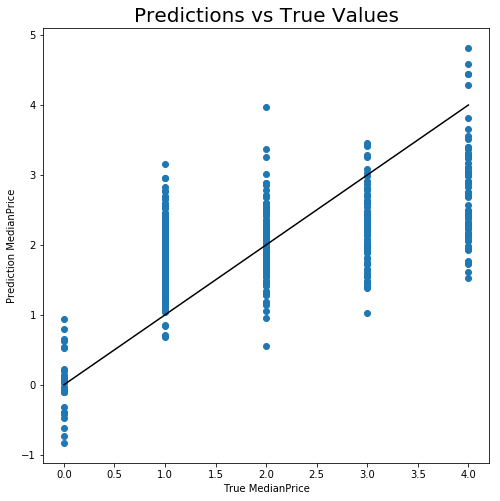

In [160]:
plt.figure(figsize=(8,8))
plt.scatter(y = model_2.predict(X_test_scaled), x = y_test)
plt.title('Predictions vs True Values', fontsize = 20)
plt.xlabel('True MedianPrice')
plt.ylabel('Prediction MedianPrice')
plt.plot([0, np.max(y)], [0, np.max(y)], c = 'k');

Let's quickly take a glance at some of the determining coeffients for this simple model:

In [161]:
model_2_coef_df = pd.DataFrame(model_2.coef_,
                       columns =['coef'])

model_2_coef_df.shape

(82, 1)

In [162]:
features_temp = ['constant'] + features


featuresdf = pd.DataFrame(features_temp,
                      columns = ['feature'])

featuresdf.shape

(82, 1)

In [163]:
pd.concat([model_2_coef_df, featuresdf], axis = 1).sort_values('coef')

,coef,feature
79,-1.872582e+13,type_Minion
80,-1.797357e+13,type_Spell
39,-8.741562e+12,cardset_Classic
73,-8.254444e+12,race_General
81,-7.620753e+12,type_Weapon
42,-7.248178e+12,cardset_Journey to Un'Goro
48,-7.097272e+12,cardset_Rastakhan's Rumble
54,-7.066561e+12,cardset_Whispers of the Old Gods
37,-7.004590e+12,cardset_Basic
50,-6.941871e+12,cardset_The Boomsday Project


Well that was fun to play around with and to get SOMETHING - but really this model is not telling us much at all, even looking at the coefficients. Let's get a multiclass classification model in here - maybe even a feed forward neural network!

## Logistic Regression - Multiclass

In [164]:
#Baseline:
y.value_counts()
#unbalanced class - something to consider!

1    713
2    519
3    339
4    299
0    133
Name: rarity_value, dtype: int64

In [175]:
logr = LogisticRegression()
ss = StandardScaler()

X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state = 42, stratify = y)

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [184]:
y_test.value_counts()

1    178
2    130
3     85
4     75
0     33
Name: rarity_value, dtype: int64

In [185]:
model_3 = logr.fit(X_train_scaled, y_train)

In [186]:
print('LogReg score on Train:', model_3.score(X_train_scaled, y_train))
print('LogReg score on Test:', model_3.score(X_test_scaled, y_test))

LogReg score on Train: 0.5692410119840213
LogReg score on Test: 0.499001996007984


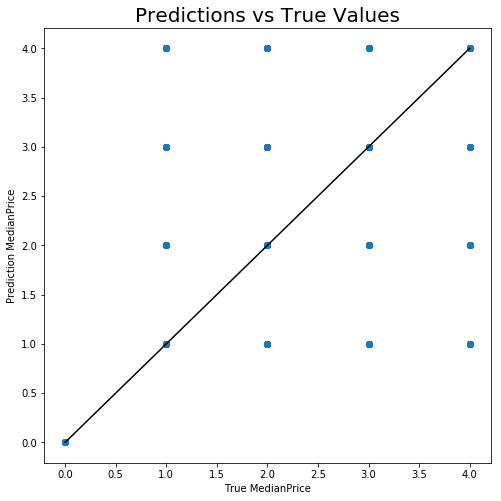

In [188]:
plt.figure(figsize=(8,8))
plt.scatter(y = model_3.predict(X_test_scaled), x = y_test)
plt.title('Predictions vs True Values', fontsize = 20)
plt.xlabel('True MedianPrice')
plt.ylabel('Prediction MedianPrice')
plt.plot([0, np.max(y)], [0, np.max(y)], c = 'k');

# lol useless - lets look at a confusion matrix!

In [189]:
confusion_matrix(y, model_3.predict(X))



array([[  1,   6,   0,  63,  63],
       [  0,  37,   3, 188, 485],
       [  0,   9,   1, 159, 350],
       [  0,   6,   0, 123, 210],
       [  0,   3,   0,  22, 274]])

In [190]:
# all of this found: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = list(unique_labels(y_test, model_3.predict(X_test)))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax




Confusion matrix, without normalization
[[  0   2   0  14  17]
 [  0  12   0  42 124]
 [  0   2   0  34  94]
 [  0   3   0  26  56]
 [  0   0   0   8  67]]
Normalized confusion matrix
[[0.   0.06 0.   0.42 0.52]
 [0.   0.07 0.   0.24 0.7 ]
 [0.   0.02 0.   0.26 0.72]
 [0.   0.04 0.   0.31 0.66]
 [0.   0.   0.   0.11 0.89]]


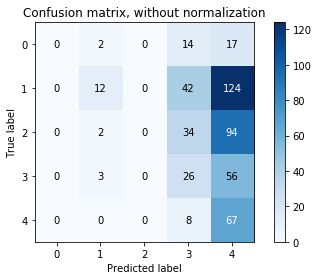

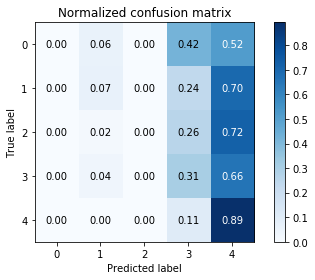

In [191]:
np.set_printoptions(precision=2)
classes = list(unique_labels(y_test, model_3.predict(X_test)))

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, model_3.predict(X_test), classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test,model_3.predict(X_test), classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Suggestion from Ritchie - we need to get some NLP stuff in here, dont we. 

## NLP Time

Help from Dave's NLP walkthrough and here:
https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer?rq=1

In [230]:
df.head()

,attack,cardId,cost,durability,health,name,rarity,text,armor,mech_Adapt,...,race_General,race_Mech,race_Murloc,race_Pirate,race_Totem,type_Hero,type_Minion,type_Spell,type_Weapon,rarity_value
0,-1.0,CS2_041,0.0,-1.0,-1.0,Ancestral Healing,Free,Restore a minionnto full Health andngive it bT...,-1.0,0.0,...,1,0,0,0,0,0,0,1,0,0
1,-1.0,CS2_072,0.0,-1.0,-1.0,Backstab,Free,Deal 2 damage to an undamaged minion,-1.0,0.0,...,1,0,0,0,0,0,0,1,0,0
2,-1.0,EX1_169,0.0,-1.0,-1.0,Innervate,Free,Gain 1 Mana Crystal this turn only,-1.0,0.0,...,1,0,0,0,0,0,0,1,0,0
3,-1.0,CS2_008,0.0,-1.0,-1.0,Moonfire,Free,Deal 1 damage,-1.0,0.0,...,1,0,0,0,0,0,0,1,0,0
4,-1.0,NEW1_003,0.0,-1.0,-1.0,Sacrificial Pact,Free,Destroy a Demon Restore 5 Health to your hero,-1.0,0.0,...,1,0,0,0,0,0,0,1,0,0


In [282]:
df['text'][1705]

'Summon copies of all Demons you control'

We need stop words - I've already played around with this a BUNCH. ngram length and stop words change the upcoming graphs drastically. A lot of words in the feault stop words list are actual VITAL in hearthstone - YOUR minion vs A minion are hugely different. I'm going to remove certain words from the stopword list:

removed:
 - "your", "yours", "you"
 - itself
 - "a", "an"
 - "they", "them", "their", "theirs", "themselves"
 -  "or", "and"
 - "during", "before"
 - "this", "that",

In [308]:
custom_stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you",
 "yourself", "yourselves", "he", "him", "his", "himself",
 "she", "her", "hers", "herself", "it", "its",  "what", "which", "who", "whom", 
 "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
 "have", "has", "had", "having", "do", "does", "did", "doing",  "the",
  "but",  "because", "as", "until", "while", "of", "at", "by", "if"
 "for", "with", "about", "against", "between", "into", "through", 
 "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", 
 "over", "under", "again", "further", "then", "once", "here", "there", "when", 
 "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", 
 "other", "some", "such", "no", "nor", "not","only", "own", "same", "so", 
 "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [309]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

cvec = CountVectorizer(tokenizer=LemmaTokenizer(),
                                ngram_range = (3,5),
                                strip_accents = 'unicode', # works 
                                stop_words = custom_stop_words, # works
                                lowercase = True) # works
                    

In [310]:
text_vect = cvec.fit_transform(df['text'])
text_vect_df = pd.DataFrame(text_vect.toarray(), columns = cvec.get_feature_names())
text_vect_df.set_index(df['rarity'], inplace=True)

In [311]:
text_vect_df.head()

,0 bjade golemb,0 bjade golemb bbattlecry,0 bjade golemb bbattlecry and,0 bjade golemb gain,0 bjade golemb gain an,0 bjade golemb give,0 bjade golemb give btauntb,0 bjade golemb or,0 bjade golemb or shuffle,0 bjade golembbstealthbnbdeathrattleb,...,youvenplayed this game,youvenplayed this game itargetsnchosen,youvenplayed this game itargetsnchosen randomlyi,’ a friendly,’ a friendly demon,’ a friendly demon give,’ attack unless,’ attack unless ’,’ attack unless ’ minion,’ minion battlefield
rarity,,,,,,,,,,,,,,,,,,,,,
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [312]:
top_free_features = text_vect_df.loc['Free'].sum().sort_values(ascending = False)[:30]
top_common_features = text_vect_df.loc['Common'].sum().sort_values(ascending = False)[:30]
top_rare_features = text_vect_df.loc['Rare'].sum().sort_values(ascending = False)[:30]
top_epic_features = text_vect_df.loc['Epic'].sum().sort_values(ascending = False)[:30]
top_legendary_features = text_vect_df.loc['Legendary'].sum().sort_values(ascending = False)[:30]

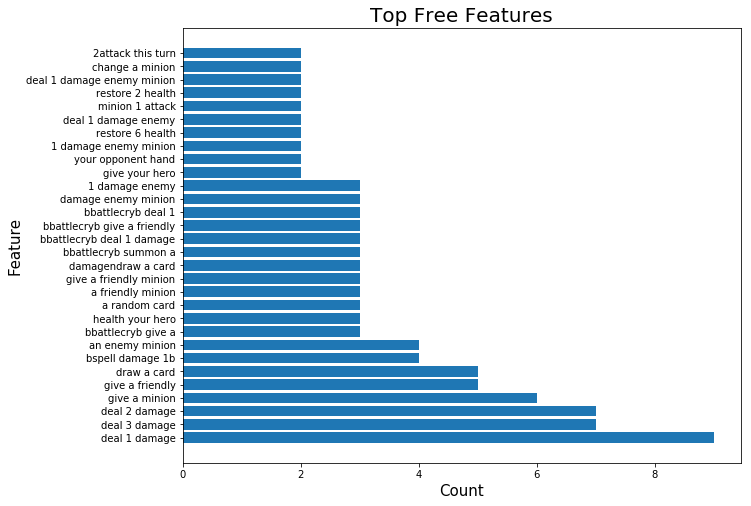

In [313]:
plt.figure(figsize = (10, 8))
plt.barh(top_free_features.index, top_free_features.values)
plt.title('Top Free Features', fontsize = 20)
plt.xlabel('Count', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.show()

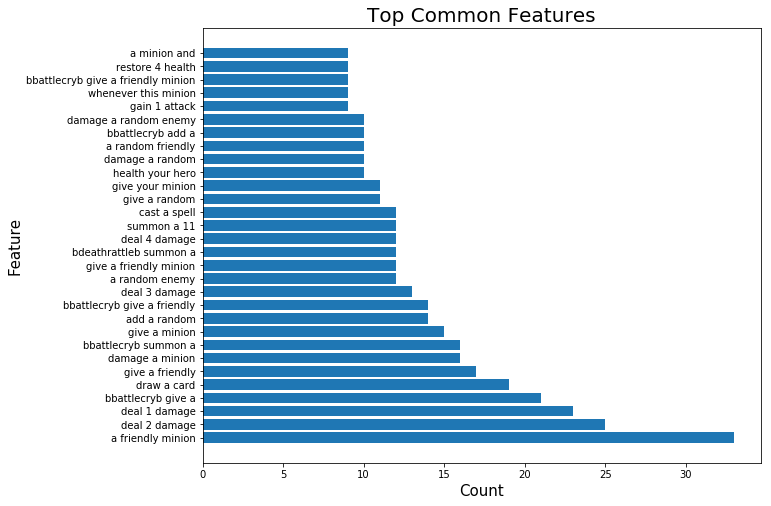

In [314]:
plt.figure(figsize = (10, 8))
plt.barh(top_common_features.index, top_common_features.values)
plt.title('Top Common Features', fontsize = 20)
plt.xlabel('Count', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.show()

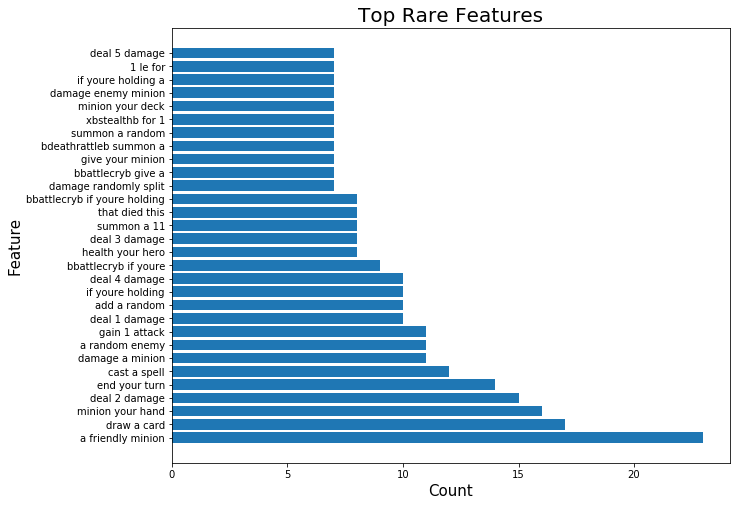

In [315]:
plt.figure(figsize = (10, 8))
plt.barh(top_rare_features.index, top_rare_features.values)
plt.title('Top Rare Features', fontsize = 20)
plt.xlabel('Count', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.show()

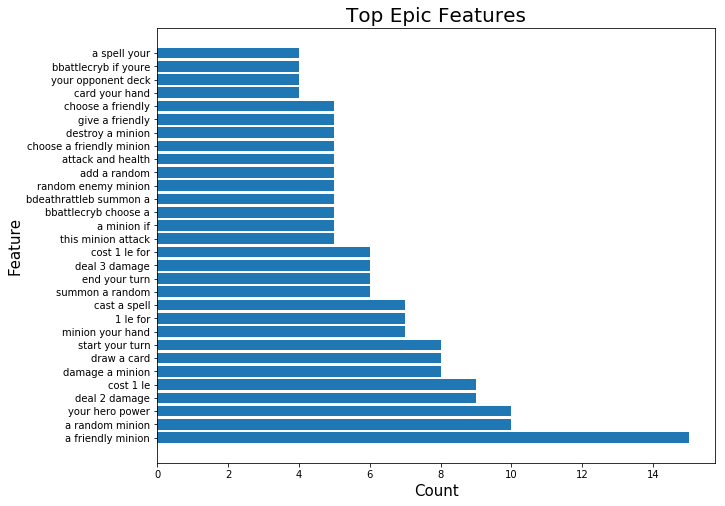

In [316]:
plt.figure(figsize = (10, 8))
plt.barh(top_epic_features.index, top_epic_features.values)
plt.title('Top Epic Features', fontsize = 20)
plt.xlabel('Count', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.show()

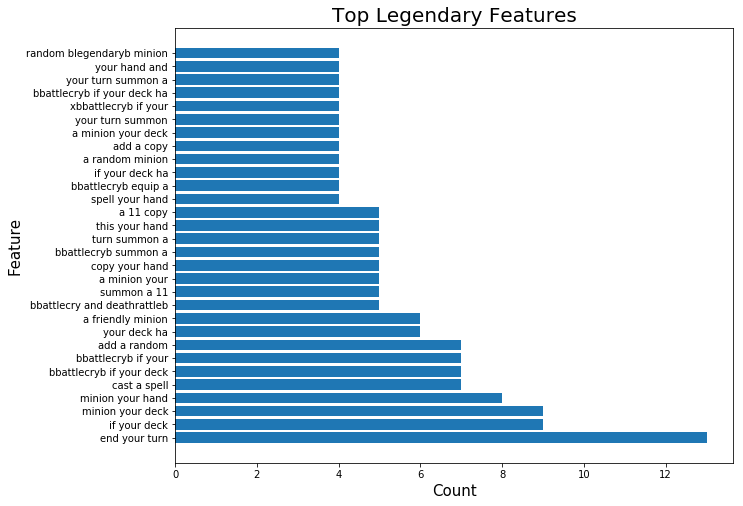

In [317]:
plt.figure(figsize = (10, 8))
plt.barh(top_legendary_features.index, top_legendary_features.values)
plt.title('Top Legendary Features', fontsize = 20)
plt.xlabel('Count', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.show()

In [318]:
## Neural Network!

In [ ]:
df_deck_archetypes = pd.read_csv('decklist_df.csv')

In [ ]:
df_deck_archetypes.head()

In [ ]:
df_deck_archetypes.stack().value_counts()

So of our 23 decks, each containing 30 cards, we have 283 unique cards. 

Normalize this! We need to definitely normalize using the CLASS of each card, and the following:

1 Archetypes of Druid: ['Token Druid']   
5 Archetypes of Hunter: ['Deathrattle Hunter' 'Mech Hunter' 'Midrange Hunter' 'Secret Hunter' 'Spell Hunter']   
2 Archetypes of Mage: ['Burn Mage' 'Khadgar Mage']   
3 Archetypes of Paladin: ['Control Paladin' 'Mech Paladin' 'Secret Paladin']   
2 Archetypes of Priest: ['Resurrect Priest' 'Silence Priest']   
3 Archetypes of Rogue: ['Miracle Rogue' 'Tempo Rogue' 'Thief Rogue']   
3 Archetypes of Shaman: ['Big Shaman' 'Murloc Shaman' 'Shudderwock Shaman']   
2 Archetypes of Warlock: ['Handlock' 'Zoo Warlock']   
4 Archetypes of Warrior: ['Big Warrior' 'Bomb Warrior' 'Control Warrior' 'Dragon Warrior']   


In [ ]:
# sudo code
df_deck_name_here = pd.DataFrame
   columns = card_name, everything else from the card set dataframe.
  

- make a model for spells, weapons, minions MASK!!! (predicting rarity)
- add feature of word count on card

- NLP on data (see daves lecture) * 

- predict a decks winrate against each class
   each row a single deck

- 


log reg: probability of winning vs losing
make dummies for every card of current standard format (kinda nlp), class winrate against other classes (
get decklist into that, 





In [ ]:
# add feature of word count on card


In [ ]:
# NLP on data

# Predict Rarity with Deck Win Data

In [ ]:
To build off in the 